# Network Visualization Next Data

In [ ]:
# Required packages
# This will install the packages only if are missing
if (!require("igraph")) install.packages("igraph")
if (!require("intergraph")) install.packages("intergraph")
if (!require("statnet")) install.packages("statnet")
if (!require("scales")) install.packages("scales")
if (!require("beepr")) install.packages("beepr")

## Data Preparation
 This section:  
 - Reads in the data frame  
 - Creates a unique labels' dataframe to feed into the graph object as the nodes/vertices list  
 - Creates a link's dataframe:   
     - "Center" is taken as the "From" node  
     - "Answer" is taken as the "To" node 
     - All nodes are directed

In [2]:
# load data
d_raw <- read.csv(file="data/animal_random_merged.csv", header=TRUE, sep=",") 

In [3]:
# create node list of unique labels
nodes <- data.frame(unique(d_raw$Center)) 
# change colname Label
nodes <- setNames(nodes, c("Label")) 
# vectors to pick
myvars <- c("Center", "Answer") 
# pick "Center" and "Answer" vectors 
links <- d_raw[myvars]  
# add vector "Type" of link 
links$Type <- rep(c("Directed"), times = length(links$Center)) 
# change col names for graph object
links <- setNames(links, c("From", "To", "Type")) 

In [4]:
# check
head(nodes)
head(links)

Label
<fct>
alligator
elk
whale
clam
goat
camel


From,To,Type
<fct>,<fct>,<chr>
alligator,rattlesnake,Directed
elk,vulture,Directed
whale,moose,Directed
clam,panda,Directed
goat,ant,Directed
camel,salamander,Directed


## Creating network object

In [5]:
library(igraph)
library(scales)

In [6]:
# we need to pass "link" as edges to "d" and "nodes" as vertices to "Vertices"
# we also set "directed" to true ("T")
net <- graph_from_data_frame(d=links, vertices=nodes, directed=T) # new igraph-network object
E(net) # edges
V(net) # vertices

+ 9928/9928 edges from f2fb435 (vertex names):
 [1] alligator  ->rattlesnake  elk        ->vulture     
 [3] whale      ->moose        clam       ->panda       
 [5] goat       ->ant          camel      ->salamander  
 [7] ox         ->polar bear   hyena      ->fowl        
 [9] muskrat    ->cockroach    mule       ->wolf        
[11] rat        ->chicken      walrus     ->heron       
[13] hornet     ->chicken      rooster    ->shrew       
[15] clam       ->pelican      armadillo  ->buzzard     
[17] swan       ->gerbil       alpaca     ->clam        
[19] lamb       ->wildebeest   bison      ->spider      
+ ... omitted several edges

+ 217/217 vertices, named, from f2fb435:
  [1] alligator       elk             whale           clam           
  [5] goat            camel           ox              hyena          
  [9] muskrat         mule            rat             walrus         
 [13] hornet          rooster         armadillo       swan           
 [17] alpaca          lamb            bison           marten         
 [21] spider          cardinal        musk ox         prairie dog    
 [25] tadpole         gnat            moth            butterfly      
 [29] vulture         anemone         mouse           woodpecker     
 [33] crane           bird            panda           wallaby        
 [37] chickadee       deer            mare            tasmanian devil
+ ... omitted several vertices

## Five-number summary

In [7]:
library(intergraph)
library(statnet)

In [9]:
# We first need to coerce the igraph object to a statnet network object
net.n <- asNetwork(net)

In [10]:
# Size: number of nodes
network.size(net.n)
## Size: 217 ##

[1] 217

In [11]:
# Density: proportion of observed ties of the maximum number of possible ties.
gden(net.n)
## Density: 0.21178955453149 ##

[1] 0.2117896

In [ ]:
# Components: is a subgroup in which all actors are connected, directly or indirectly. 

#Find strong components
comp = components(net.n,connected="strong")
# check help(component.dist) for details about how components are identified
# Components: 2

In [ ]:
# Diameter (geodesic distance): is the longest of the shortest paths across all pairs of nodes
# Is measure of compactness
lgc <- component.largest(net.n,result="graph")
gd <- geodist(lgc)
max(gd$gdist)
## Diameter: 3 ##

In [13]:
# Clustering coefficient: is the presence of clustering, or the tendency to formed closed triangles

# we first need to check if the network is multiplex 
# (multiple directed edges between a pir of nodes)
is.multiplex(net.n)

[1] TRUE

In [14]:
# It is, so let's remove loops and multiple edges to simplify the net
net.s <- simplify(net, remove.multiple = T, remove.loops = T)

In [15]:
# Let's coerce the igraph object to a statnet network object again
net.n.s <- asNetwork(net.s)

In [16]:
# Now use gtrans to compute diamater
gtrans(net.n.s,mode="graph")
## Diameter: 0.198555000965171 ##

[1] 0.198555

In [18]:
#################
### Basic Summary
#################
## Size:       217  ##
## Density:    0.21 ##
## Components: 2    ##
## Diameter:   3    ##
## Clustering: 0.19 ##

## Basic Network plotting 

In [17]:
library(scales)
library(beepr)

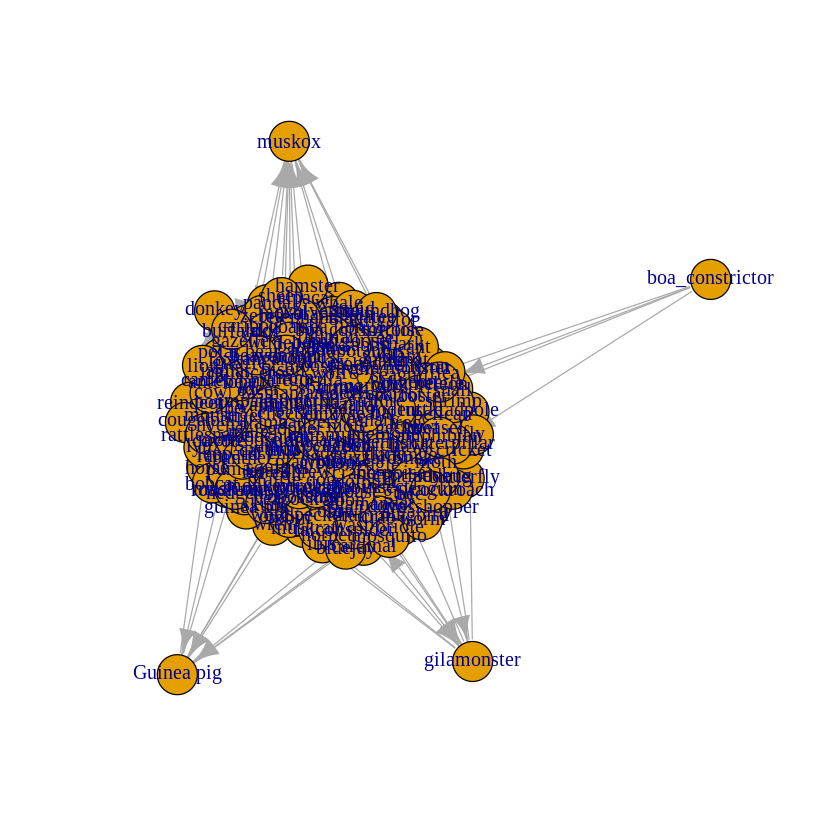

In [18]:
# First raw plot
plot(net.s)

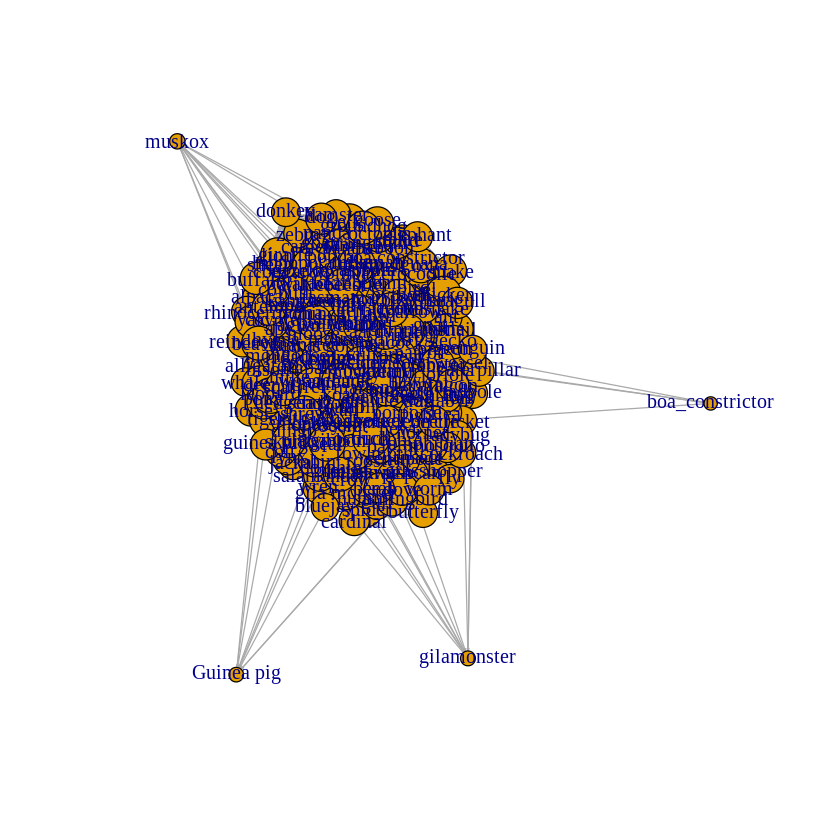

In [19]:
# Compute node degrees (#links) and use that to set node size:
deg <- degree(net.n.s)
deg <- rescale(deg, to = c(5, 15)) # resize node size 
V(net.s)$size <- deg
plot(net.s, edge.arrow.size=.1) # reduce arrow size

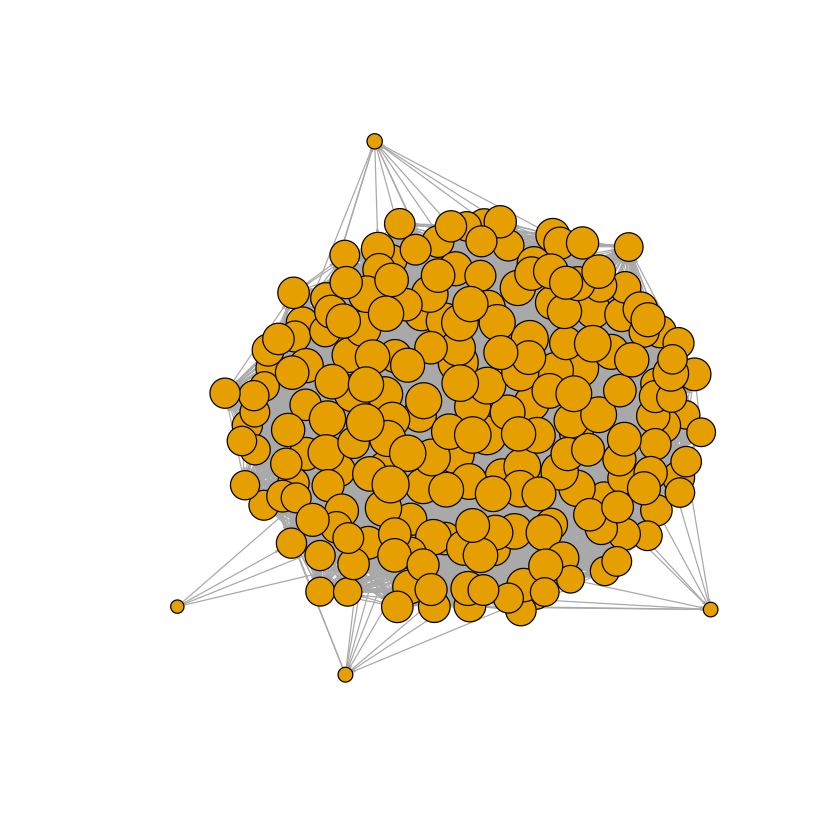

In [20]:
# Let's remove labels from the graph to see how it looks
lk = layout.kamada.kawai(net.s) # create a tree like layout
plot(net.s, edge.arrow.size=.1,vertex.label=NA, layout = lk)

## Community detection

In [21]:
# cluster edge betweenness
# The idea of the edge betweenness based community structure detection 
# is that it is likely that edges connecting separate modules have high 
# edge betweenness as all the shortest paths from one module to another 
# must traverse through them.

# This may take a minute to run...
clp_e <- cluster_edge_betweenness(net.s)
beep(sound = 8) # sound when finish

In [24]:
# cluster random walk
# This function tries to find densely connected subgraphs, also called 
# communities in a graph via random walks. The idea is that short random
# walks tend to stay in the same community.

# Note: this works only for undirected graphs, hence, it will ignore 
# edge direction

clp_r <- cluster_walktrap(net.s)
beep(sound = 2) # sund when finish

In [25]:
# The cluster function returns a community object
class(clp_e)
class(clp_r)

[1] "communities"

[1] "communities"

In [26]:
# number of communities detected by each algorithm
length(clp_e) 
length(clp_r) 

[1] 24

[1] 4

In [27]:
# here we can check the community at which each node was assigned 
head(clp_e$membership) 
head(clp_r$membership) 

[1] 1 2 3 4 2 5

[1] 2 2 2 1 2 2

In [28]:
# how modular the graph partitioning is
# High modularity for a partitioning reflects dense connections within 
# communities and sparse connections across communities.

modularity(clp_e)
modularity(clp_r)

[1] 0.000674628

[1] 0.07381853

In [29]:
###############
# Basic Summary
###############
# Edge betweenness ##
# Communities: 24
# Modularity: 0.00067
#####################
# Random trap (walk)#
# Communities: 4
# Modularity: 0.07381
#####################

# IMPORTANT: There is massive difference between detecting communties
# by a random walk that assumes undirected edges, and edge_betweenness
# that works with directed edges

## Better plotting

In [30]:
# create a tree like layout
lk = layout.kamada.kawai(net.s) 

In [31]:
# Let's create a color pallete for edge_betweenness communities

prettyColors <- rainbow(length(clp_e), alpha = 0.7)
communityColors_e <- prettyColors[membership(clp_e)]

# Let's create a color pallete for random_walk_trap communities
prettyColors <- rainbow(length(clp_r), alpha = 0.7)
communityColors_r <- prettyColors[membership(clp_r)]

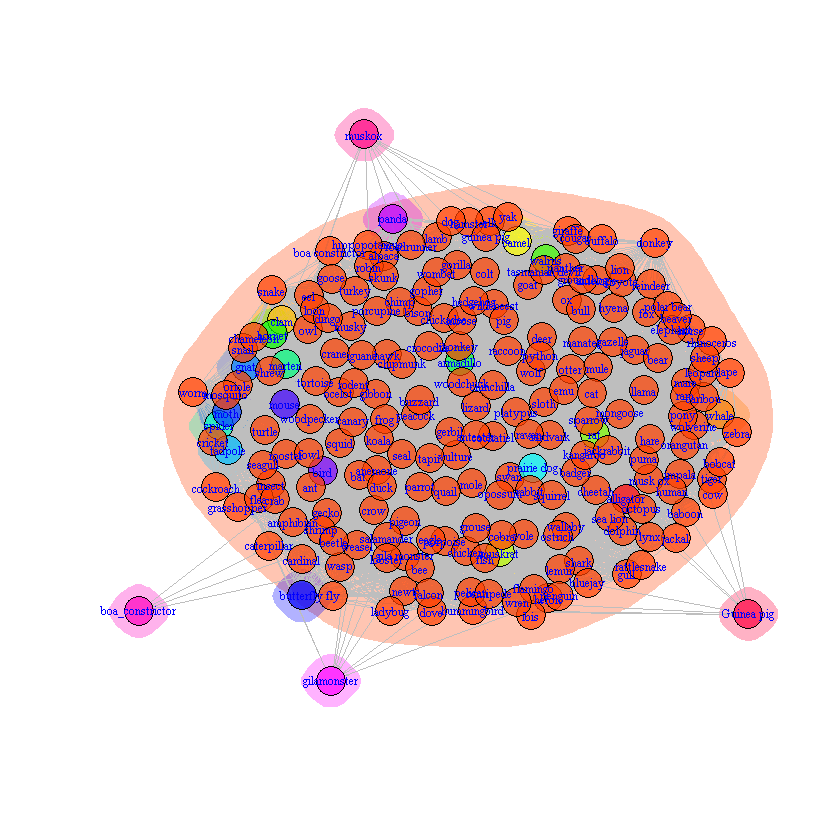

In [32]:
## GRAPH 1 ##

# Let's plot the edge_betweenness result with lk layout
# Note: since there are communities of "1" or very few nodes, the layout.fruchterman.reingold
# won't work well

set.seed(28) # set seed for reproducibility

plot(clp_e, net.s, edge.width = 0.1, mark.border=NA, vertex.label.cex=0.6, 
     vertex.label.color="blue", vertex.size = 10, edge.arrow.size=0.1, 
     edge.color = "Grey", col = communityColors_e, layout= lk, asp =0)

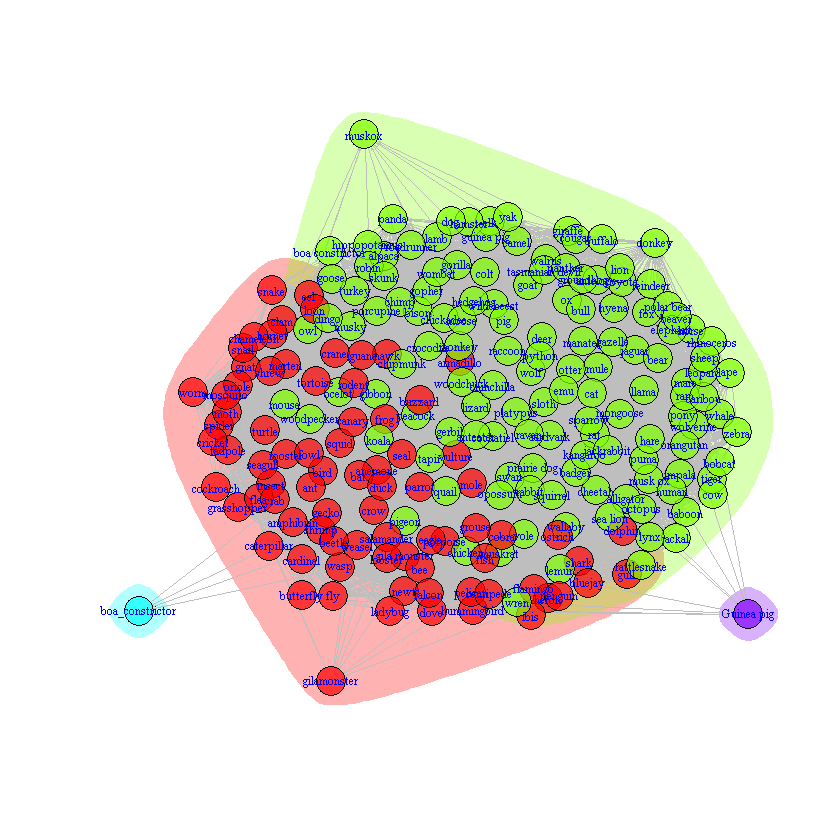

In [33]:
## GRAPH 2 ##

# Let's plot the random_walk_trap result with lk layout
# Note: since there are communities of "1" or very few nodes, the layout.fruchterman.reingold
# won't work well

set.seed(28) # set seed for reproducibility

plot(clp_r, net.s, edge.width = 0.1, mark.border=NA, vertex.label.cex=0.6, 
     vertex.label.color="blue", vertex.size = 10, edge.arrow.size=0.1, 
     edge.color = "Grey", col = communityColors_r, layout= lk, asp =0)

In [34]:
## Plot out GRAPH 1 ##
set.seed(28) # set seed for reproducibility

tiff("plot_next_animal_eb.tiff", width =5, height = 5, units = 'in', res = 300, compression = 'none')

plot(clp_e, net.s, edge.width = 0.1, mark.border=NA, vertex.label.cex=0.5, 
     vertex.label.color="blue", vertex.size = 10, edge.arrow.size=0.1, 
     edge.color = "Grey", col = communityColors_e, layout= lk, asp =0)

dev.off()

png 
  2

In [35]:
## Plot out GRAPH 2 ##
set.seed(28) # set seed for reproducibility

tiff("plot_next_animal_rw.tiff", width =5, height = 5, units = 'in', res = 300, compression = 'none')

plot(clp_r, net.s, edge.width = 0.1, mark.border=NA, vertex.label.cex=0.5, 
     vertex.label.color="blue", vertex.size = 10, edge.arrow.size=0.1, 
     edge.color = "Grey", col = communityColors_r, layout= lk, asp =0)

dev.off()

png 
  2